# Task 1: Less Than k

#### Given a positive integer k and a list of positive integer numbers, look for the numbers within the list, that are less than k

## Loading Libraries:

In [1]:
import numpy as np
import math
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.basis_change import QFT

## Applying X-Gates Given An Integer:
#### The following function applies X-gates corresponding to the binary representation of an integer.

In [2]:
def bit_circuit(size, number):
    # Constructs a quantum circuit with a given number of qubits
    b_circuit = QuantumCircuit(size)
    
    # Applies X-gates corresponding to the binary representation of a negative integer
    if number < 0:
        for i in range(size):
            if bin((1 << size) + number)[2:].zfill(size)[-i-1] == '1':
                b_circuit.x(i)
                
    # Applies X-gates corresponding to the binary representation of a positive integer 
    else:
        for i in range(size):
            if bin(number)[2:].zfill(size)[-i-1] == '1':
                b_circuit.x(i)
    return b_circuit

## Targeting Elements:
#### The following function will target the bits which represent elements in our list.

In [3]:
def target_set_circuit(size, input_list):
    # Constructs a quantum circuit with a given number of qubits 
    ts_circuit = QuantumCircuit(size+1)
    
    # Marks elements in the given list by bit flipping the ancilla from a 0 to a 1
    for i in range(len(input_list)):
        
        # Applies X-gates to the bitwise complement of an element in the list
        ts_circuit.append(bit_circuit(size, 2**(size-1) - 1 - input_list[i]), range(size))
        
        # Bit flips the ancilla on the all 1's state which corresponds to an element in the given list
        ts_circuit.mcx(list(range(size-1)),size)
        
        # Reverses back to the previous state with the ancilla still flipped
        ts_circuit.append(bit_circuit(size, 2**(size-1) - 1 - input_list[i]), range(size))
    return ts_circuit

## Constructing The Quantum Adder:
#### Through the quantum fourier transform, the following function adds the first register onto the second. This eliminates the need for temporary qubits.

In [4]:
def quantum_add_circuit(size):
    # The first register stores our target k and the second register stores the elements in the list
    qa_circuit = QuantumCircuit(2*size)
    
    # The following gate changes the basis of the second register from the computational basis to the fourier basis
    qa_circuit.append(QFT(size, do_swaps=False), list(range(size, 2*size)))
    
    # Constructs a circuit which counts in the fourier basis by applying rotations in the presence of 1 qubits
    for j in range(size):
        for k in range(size-j):
            lamda = np.pi / (2 ** (k))
            qa_circuit.cp(lamda, j, k+j+size)
            
    # This gate changes from the Fourier basis back to the computational basis        
    qa_circuit.append(QFT(size, do_swaps=False).inverse(), list(range(size, 2*size)))
    return qa_circuit

## Constructing The Oracle:
#### Since n<k is equivalent to n+(-k)<0, the following circuit performs a phase flip on the states in our set whose sum with (-k) is negative. This is achieved by targeting states leading with 11 where the first 1 is the ancilla indicating the element is in the set and the second 1 implies that the element after the sum in bit representation is negative.  

In [5]:
def oracle_circuit(target, size, input_list):
    # Constructs a circuit for the two registers as well as the one ancilla
    o_circuit = QuantumCircuit(2*size+1)
    
    # Applies X-gates to the first register corresponding to the bit representation of a negative number
    o_circuit.append(bit_circuit(size,-target),range(size))
    
    # Adds circuit which targets elements in the given list
    ts_circuit = target_set_circuit(size, input_list)
    o_circuit.append(ts_circuit, range(size, 2*size+1))
    
    # Adds circuit which adds the first register corresponding to (-k) to our second register of elements
    qa_circuit = quantum_add_circuit(size)
    o_circuit.append(qa_circuit, range(2*size))
    
    # Performs a phase flip on states corresponding to elements n in the set where n+(-k)<0
    o_circuit.cz(2*size-1, 2*size)
    
    # Reverses the process by adding k to the second register n+(-k) while preserving the sign change
    o_circuit.append(bit_circuit(size,-target),range(size))
    o_circuit.append(bit_circuit(size,target),range(size))
    o_circuit.append(qa_circuit, range(2*size))
    o_circuit.append(bit_circuit(size,target),range(size))
    
    # Continues reversing the process by bit flipping the ancilla back to 0
    o_circuit.append(ts_circuit,range(size, 2*size+1))
    return o_circuit

## Constructing The Diffusion Operator:
#### The following circuit applies the diffusion operator which amplifies the correct states.

In [6]:
def diffusion_circuit(size):
    # Since the list is positive, we only apply the diffusion operator on the last (n-1) qubits in the register
    d_circuit = QuantumCircuit(size-1)
    
    # Reverses our state which was initialized with Hadamard gates
    d_circuit.h(range(size-1))
    d_circuit.barrier(range(size-1))
    
    # Performs the reflection across the all 0's state
    d_circuit.x(range(size-1))
    d_circuit.h(size-2)
    d_circuit.mct(list(range(size-2)), size-2) 
    d_circuit.h(size-2)
    d_circuit.x(range(size-1))
    d_circuit.barrier(range(size-1))
    
    # Reinitializes our state by applying Hadamard gates 
    d_circuit.h(range(size-1))
    d_circuit.barrier(range(size-1))
    return d_circuit

## Implementing Grover's Algorithm:
#### The following circuit implements Grover's Algorithm by applying the oracle and the diffusion operator. 

In [7]:
def less_than_k_circuit(target, input_list):
    # Determines the necessary size of the circuit
    size = max(int(np.log2(max(input_list)))+1, int(np.log2(target))+1) + 1
    
    # Constructs the first register, second register, the ancilla, and the bits required for measurement
    lk_circuit = QuantumCircuit(2*size+1, size-1)
    
    # Initializes to the equal superposition state
    lk_circuit.h(range(size, 2*size-1))
    
    # Applies the oracle to phase flip the correct states
    o_circuit = oracle_circuit(target, size, input_list)
    lk_circuit.append(o_circuit, range(2*size+1))
    
    # Applies the diffusion operator to amplify the correct states
    d_circuit = diffusion_circuit(size)
    lk_circuit.append(d_circuit, range(size, 2*size-1))
    
    # Measures the last (n-1) quibits of the second register
    lk_circuit.measure(list(range(size, 2*size-1)),list(range(size-1)))
    return lk_circuit

## Determining The Subset:
#### We run an arbitrary number of simulations to find the most probable subset of elements less than k. 

In [8]:
def less_than_k(target, input_list, augment = False):
    # Checks if the target k is positive
    if target <= 0:
        print("The input " + str(target) + " is not positive.")
        return None, None
        
    # Checks if the set is nonempty
    elif not input_list:
        print("The list " + str(input_list) + " does not contain any elements.")
        return None, None
    
    # Checks if the set only contains positive integers
    elif min(input_list) <= 0:
        print("The list " + str(input_list) + " does not contain only positive elements.")
        return None, None
     
    # Performs Grover's algorithm if k is positive and the set only contains positive elements
    else: 
        # Setting up the simulator
        simulator = Aer.get_backend('qasm_simulator')
        
        # This statement will be discussed in the test cases
        if augment:
            input_list = input_list + [2**(int(np.log2(target)) + 1)]
        
        # Simulates circuit
        lk_circuit = less_than_k_circuit(target, input_list)
        count_quantum_circuit = execute(lk_circuit, backend = simulator, shots = 10000).result().get_counts()
        
        # Constructs a descending list based on the counts from the measurements
        sorted_by_counts = sorted(count_quantum_circuit.items(), key=lambda x:x[1], reverse = True)
        
        # Creates list of the most probable subset
        less_than_k_list = []
        
        # Checks each bit from most counts to least counts
        for i in range(len(sorted_by_counts)):
            if int(sorted_by_counts[i][0],2) < target and int(sorted_by_counts[i][0],2) in input_list:
                less_than_k_list.append(int(sorted_by_counts[i][0],2))
            
            # Once the check fails, it is assumed that all of the remaining states were not amplified
            else:
                break
                
        # The element added from the previous augmentation is removed
        if augment:
            input_list.pop()
        
        # Prints the most probable subset
        print("The subset " + str(less_than_k_list) + " are the elements in " + str(input_list) +
            " that are less than " + str(target) + ".")
        return less_than_k_list, count_quantum_circuit

# Testing:
#### We test the function for various inputs.

## Test 1:

In [9]:
(subset_1, count_1) = less_than_k(7,[4,9,11,14,1,13,6,15])

The subset [4, 1, 6] are the elements in [4, 9, 11, 14, 1, 13, 6, 15] that are less than 7.


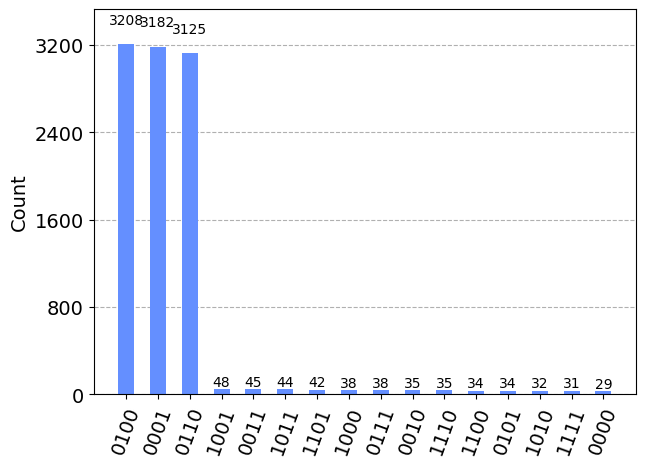

In [10]:
# Plots the number of counts in decreasing order
plot_histogram(count_1, sort='value_desc')

#### We can see that the states 0100, 0001, and 0110 have been amplified. This corresponds to the numbers 4, 1, and 6 which we add to our subset

## Test 2:

In [11]:
(subset_2, count_2) = less_than_k(6,[1,2,4,5])

The subset [] are the elements in [1, 2, 4, 5] that are less than 6.


#### From this test, we can see that there is an issue. The problem arises from Grover's algorithm for when half of the states are correct. This implies that none of the states will be amplified during reflection which we can see in the plot below.

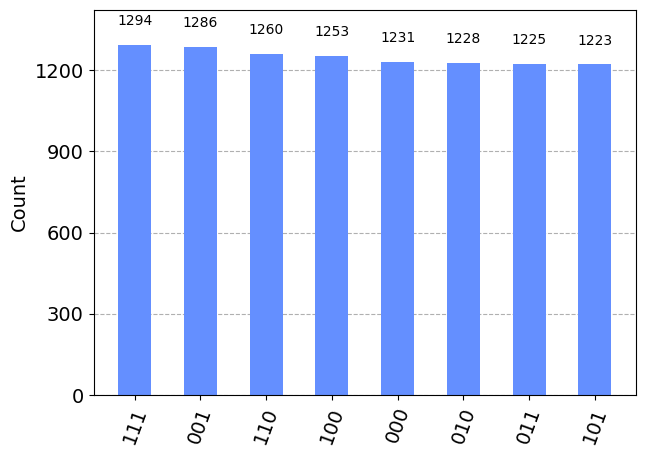

In [12]:
# Plots the number of counts in decreasing order
plot_histogram(count_2, sort='value_desc')

#### In order to resolve this, we augment the circuit to have incorrect states. Although this increases the number of qubits, it guarantees that there will be more incorrect states than correct states. This allows the correct states to be amplified which we can see below.

In [13]:
(subset_2_augment, count_2_augment) = less_than_k(6,[1,2,4,5],augment=True)

The subset [2, 4, 5, 1] are the elements in [1, 2, 4, 5] that are less than 6.


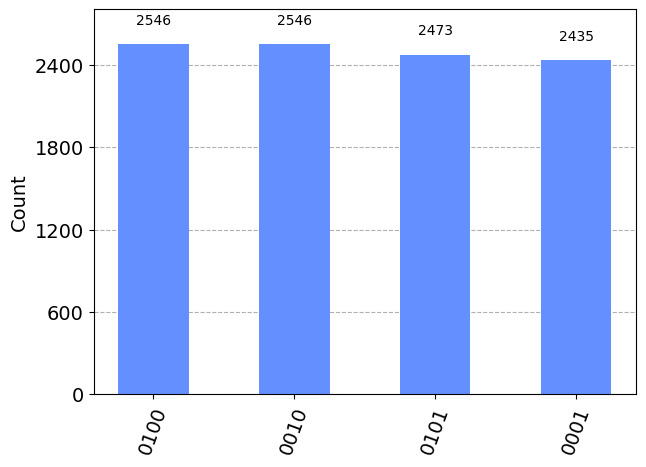

In [14]:
# Plots the number of counts in decreasing order
plot_histogram(count_2_augment, sort='value_desc')

#### Originally with 3 qubits, the correct states were not amplified. However, the correct states are amplified using 4 qubits. 

## Test 3:

In [15]:
(subset_3, count_3) = less_than_k(7,[1,2,3,4,5,6])

The subset [] are the elements in [1, 2, 3, 4, 5, 6] that are less than 7.


#### From this test, we can again see that there is an issue. Another problem arises from Grover's algorithm for when more than half  of the states are correct. Since there are less incorrect states, the incorrect states will instead be amplified during reflection which can be seen below.

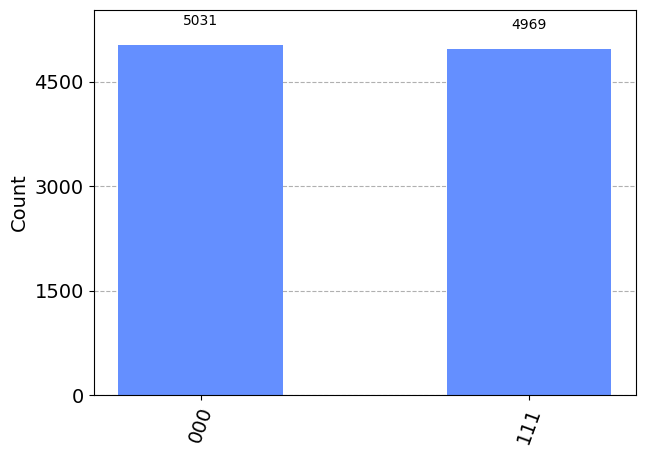

In [16]:
# Plots the number of counts in decreasing order
plot_histogram(count_3, sort='value_desc')

#### We can see that 000 and 111 which correspond to 0 and 7 are amplified. The incorrect states form a subset [0,7] which is the complement of the actual subset [1,2,3,4,5,6]. In order to resolve this, we again augment the circuit to have more incorrect states. This guarantees that there will be more incorrect states than correct states which  allows the correct states to be amplified. We can see this below.

In [17]:
(subset_3_augment, count_3_augment) = less_than_k(7,[1,2,3,4,5,6],augment=True)

The subset [6, 1, 5, 4, 2, 3] are the elements in [1, 2, 3, 4, 5, 6] that are less than 7.


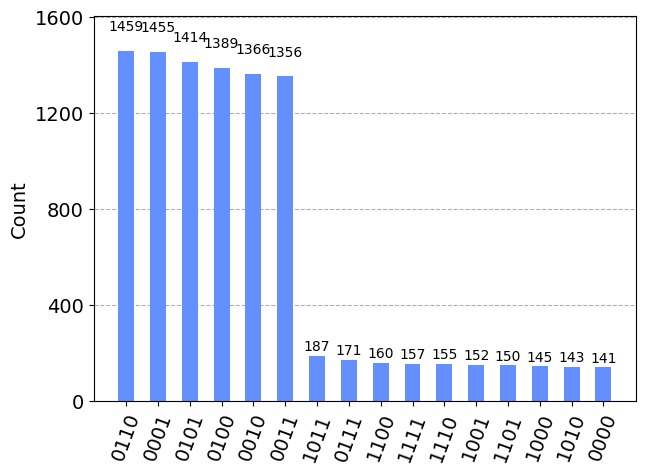

In [18]:
# Plots the number of counts in decreasing order
plot_histogram(count_3_augment, sort='value_desc')

#### Originally with 3 qubits, the incorrect states were amplified. However, the correct states are amplified using 4 qubits.

## Test 4:
#### We now test a few larger sets.

In [19]:
(subset_4, count_4) = less_than_k(40,[16,17,14,44,2,51,31,54,47,7,35,59,42,57,56])

The subset [2, 16, 31, 35, 14, 17, 7] are the elements in [16, 17, 14, 44, 2, 51, 31, 54, 47, 7, 35, 59, 42, 57, 56] that are less than 40.


## Test 5:

In [20]:
(subset_5, count_5) = less_than_k(73,[4,62,104,80,43,26,64,11,48,23,101,79,89,41,127,31,107,97,76])

The subset [48, 31, 62, 41, 11, 4, 26, 64, 23, 43] are the elements in [4, 62, 104, 80, 43, 26, 64, 11, 48, 23, 101, 79, 89, 41, 127, 31, 107, 97, 76] that are less than 73.


## Drawing The Circuit:
#### We draw an example of the involved circuit. 

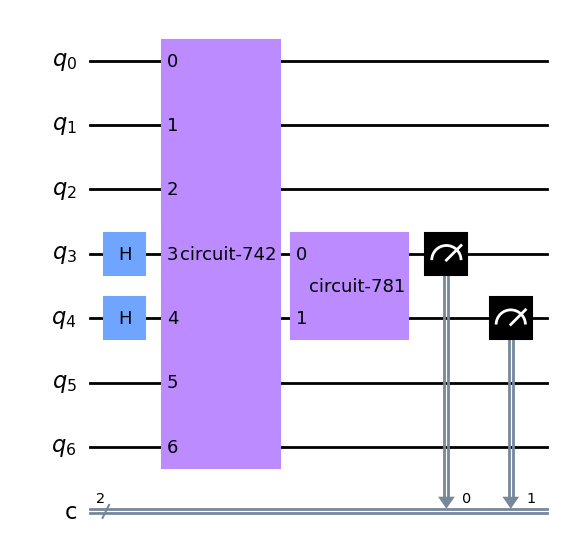

In [21]:
less_than_k_circuit(2,[1]).draw('mpl')

## Remark:
#### We have constructed a quantum circuit which looks for numbers within a given list that are less than k. From a given list and target number, the number of qubits required is 2n+1. In the first and second register, we have n qubits where n represents the number of bits required to represent the largest integer between elements of the list and the target number, and the last qubit is the ancilla which is required to mark the solution states. Furthermore, if we augment the set, the number of qubits required is 2n+3 where we include an additional bit to both the first and second register.